<a href="https://colab.research.google.com/github/danyala1/laba5_pp/blob/master/laba5_pp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from numpy import loadtxt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
from tqdm import trange

import nltk
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [2]:
torch.cuda.is_available()

True

In [3]:
!nvidia-smi

Thu Dec 22 19:17:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    25W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Необходимо загрузить исходный набор данных и соответствующие метки классов.

In [7]:
with open("/content/number_star.txt","r+") as file:
  number_star=file.read()
  number_star=number_star.split(", ")

with open("/content/text_opinions.txt","r+") as file:
  text_opinion=file.read()
  text_opinion=text_opinion
  text_opinion=text_opinion.split("', '")
  

Произвести разделение загруженного набора данных на обучающую, тестовую и валидационую выборки (в соотношении 80:10:10). Проверить, что сформированные выборки сбалансированы.

In [8]:
train_opinion=text_opinion[0:240]
train_star=number_star[0:240]
train_opinion=train_opinion+text_opinion[1840:2080]
train_star=train_star+number_star[1840:2080]
train_opinion=train_opinion+text_opinion[2380:2620]
train_star=train_star+number_star[2380:2620]
train_opinion=train_opinion+text_opinion[2800:3040]
train_star=train_star+number_star[2800:3040]
train_opinion=train_opinion+text_opinion[3134:3374]
train_star=train_star+number_star[3134:3374]


test_opinion=text_opinion[240:270]
test_star=number_star[240:270]
test_opinion=test_opinion+text_opinion[2080:2110]
test_star=test_star+number_star[2080:2110]
test_opinion=test_opinion+text_opinion[2620:2650]
test_star=test_star+number_star[2620:2650]
test_opinion=test_opinion+text_opinion[3040:3070]
test_star=test_star+number_star[3040:3070]
test_opinion=test_opinion+text_opinion[3374:3370]
test_star=test_star+number_star[3374:3370]


valid_opinion=text_opinion[270:300]
valid_star=number_star[270:300]
valid_opinion+=text_opinion[2110:2140]
valid_star+=number_star[2650:2680]
valid_opinion+=text_opinion[2650:2680]
valid_star+=number_star[3040:3070]
valid_opinion+=text_opinion[3370:3400]
valid_star+=number_star[3370:3400]

Написать модель нейронной сети для решения задачи классификации.

In [9]:
train_df = pd.DataFrame({"star": train_star, "text": train_opinion})

remove_non_alphabets =lambda x: re.sub(r'[^а-яА-Я]',' ',x)
tokenize = lambda x: word_tokenize(x)
ps = PorterStemmer()
stem = lambda w: [ ps.stem(x) for x in w ]
lemmatizer = WordNetLemmatizer()
leammtizer = lambda x: [ lemmatizer.lemmatize(word) for word in x ]


In [10]:
max_words = 10000
cv = CountVectorizer(max_features=max_words, stop_words='english')
sparse_matrix = cv.fit_transform(train_df['text'] ).toarray()
sparse_matrix.shape
x_train, x_test, y_train, y_test = train_test_split(sparse_matrix, np.array(train_df['star']))

In [11]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(10000, 100)
        self.linear2 = nn.Linear(100, 10)
        self.linear3 = nn.Linear(10, 6)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

model = LogisticRegression()
criterion = nn.CrossEntropyLoss()
x_train = torch.Tensor(x_train).float()
y_train=[int(i) for i in y_train]
y_train = torch.Tensor(y_train).long()

100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


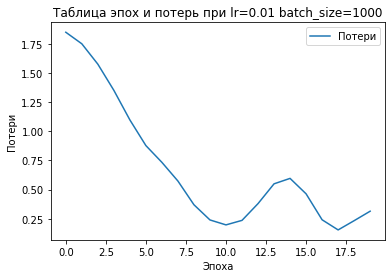

100%|██████████| 20/20 [00:03<00:00,  6.47it/s]


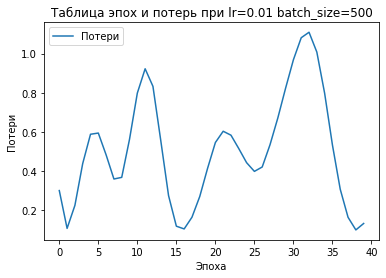

100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


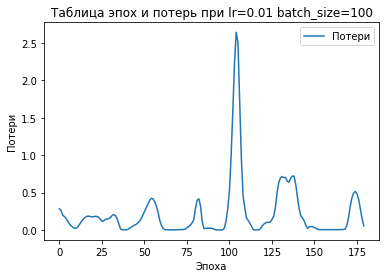

100%|██████████| 20/20 [00:01<00:00, 12.49it/s]


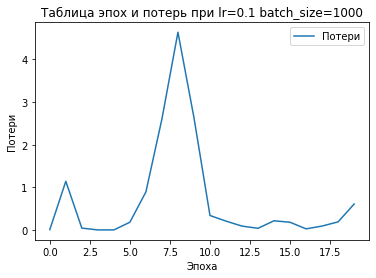

100%|██████████| 20/20 [00:02<00:00,  6.73it/s]


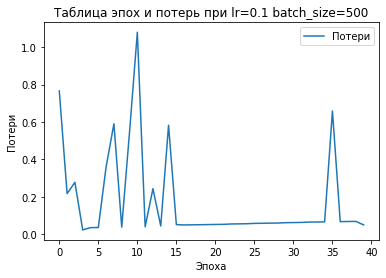

100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


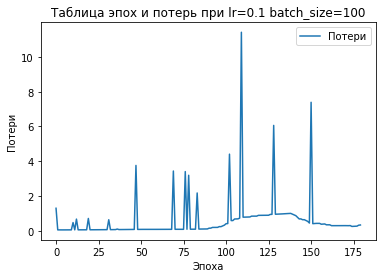

100%|██████████| 20/20 [00:01<00:00, 12.57it/s]


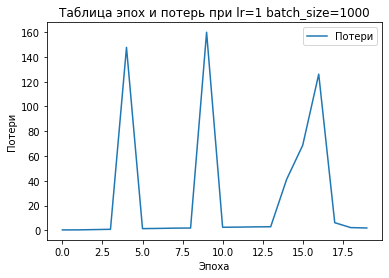

100%|██████████| 20/20 [00:02<00:00,  6.69it/s]


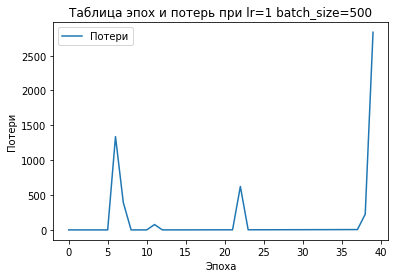

100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


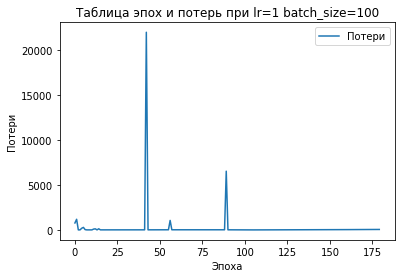

In [12]:
torch.device("cuda")

lr_list=[0.01,0.1,1]
batch_size=[1000,500,100]
for LR in lr_list:
  for BZ in batch_size:
    data=torch.utils.data.DataLoader(x_train, batch_size=BZ)
    optimizer = torch.optim.Adam(params=model.parameters() , lr=LR)
    epochs = 20
    model.train()
    loss_values = []
    for epoch in trange(epochs):
        for elems in data: 
         # optimizer.zero_grad()
          y_pred = model(x_train)
          loss = criterion(y_pred, y_train)
          loss_values.append(loss.item())
          pred = torch.max(y_pred, 1)[1].eq(y_train).sum()
          acc = pred * 100.0 / len(x_train)
          #print('Epoch: {}, Loss: {}, Accuracy: {}%'.format(epoch+1, loss.item(), acc.numpy()))
          loss.backward()
          optimizer.step()
    plt.plot(loss_values)
    plt.title('Таблица эпох и потерь при lr='+str(LR) +" batch_size="+str(BZ))
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.legend(['Потери'])
    plt.show()
   

In [13]:
x_test = torch.Tensor(x_test).float()
y_test=[int(i) for i in y_test]
y_test = torch.Tensor(y_test).long()
model.eval()
with torch.no_grad():
  for i in range(20):
      y_pred = model(x_test)
      loss = criterion(y_pred, y_test)
      pred = torch.max(y_pred, 1)[1].eq(y_test).sum()
  print ("Accuracy : {}%".format(100*pred/len(x_test)))

Accuracy : 23.66666603088379%


Сделайте выводы по полученным результатам проведенных экспериментов. Какую модель из всех полученных стоит использовать?

In [14]:
LR=0.01
BZ=100

Сохранить обученную модель.